In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from torch.utils.data import DataLoader, ConcatDataset,Dataset
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn
from torchinfo import summary

In [2]:
# Path to your dataset folder
path = "../new_data"

In [3]:
num_epochs = 3  # Number of epochs
learning_rate = 0.01  # Learning rate
device = 'cpu'

In [4]:
def strokeToImage(strokes):

    def rotate(x, y, angle):
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        x_rot = c * x - s * y
        y_rot = s * x + c * y
        return x_rot, y_rot
    
    x, y = strokes[0][0], strokes[0][1]

    # Create a figure and canvas to render the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    canvas = FigureCanvas(fig)
    
    for stroke in strokes:
        dx, dy, pen_up = stroke
        
        
        new_x, new_y = x+dx, y+dy  

        if pen_up == 0:
            ax.plot([x,new_x], [y,new_y], color='black')

        x, y = new_x, new_y

    # Set limits for the plot
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    
    # Remove axis ticks and labels for a clean image
    ax.axis('off')

    # Render the plot to the canvas
    canvas.draw()

    # Convert the canvas to a NumPy array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    
    # Get the width and height from the figure
    width, height = fig.get_size_inches() * fig.get_dpi()

    # Reshape the buffer to the correct dimensions (height, width, 3) for an RGB image
    image = image.reshape(int(height), int(width), 3)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # bw_img will be of shape (32, 32)

    
    plt.close(fig)
    
    return np.rot90(img,k=2)

import numpy as np

def strokeProcess(strokes, limit):
    # Create the placeholder array
    place_holder = np.array([[0, 0, 1]])

    # Add initial placeholder stroke
    strokes = np.vstack([place_holder, strokes])

    # Get the length of the strokes array
    leng = len(strokes)

    if leng < limit:
        # If there are fewer strokes than the limit, pad with placeholders
        padding = np.tile(place_holder, (limit - leng, 1))
        strokes = np.vstack([strokes, padding])
    else:
        # If there are more strokes than the limit, truncate to the limit
        strokes = strokes[:limit]

    # Append a final placeholder stroke
    strokes = np.vstack([strokes, place_holder])
    
    return strokes

In [5]:
# dataloader
class customDataset(Dataset):
    def __init__(self,strokes_path,split,transform=None):
        self.strokes_path = strokes_path
        self.split = split
        self.transform = transform
        self.data = np.load(self.strokes_path,encoding='latin1',allow_pickle=True)[split]

        
        


    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, index):
        strokes = self.data[index]
        half_strokes = strokes[:int(len(strokes) / 2), :]

        img = strokeToImage(half_strokes)  # Image from half-drawn strokes
        later_strokes = strokes[int(len(strokes) / 2):, :]
        later_strokes = strokeProcess(later_strokes, 100)

        ref_img = strokeToImage(strokes)  # You may change this to select a different reference image

        if self.transform:
            img = self.transform(img)
            ref_img = self.transform(ref_img)

        # Convert the 2D image to a 3D tensor by adding a channel dimension (1, height, width)
        img = torch.tensor(img.copy(), dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        ref_img = torch.tensor(ref_img.copy(), dtype=torch.float32).unsqueeze(0)  # Reference image tensor
        later_strokes = torch.tensor(later_strokes, dtype=torch.float32)
        later_strokes = later_strokes
          # Convert strokes to tensor

        return img, ref_img, later_strokes




# Initialize an empty list to store the datasets
train_datasets = []
test_datasets = []
val_datasets = []

# Loop through the files in the directory
for folder in os.listdir(path):
    # Check the file extension and name format
    print(folder)
    
    if folder.split('.')[1] != "full":
        folder_path = os.path.join(path, folder)

        try:
            # Assuming customDataset is your function or class that loads the dataset
            train_data = customDataset(folder_path, "train")
            test_data = customDataset(folder_path, "test")
            val_data = customDataset(folder_path, "valid")

            # Append the dataset to the list
            train_datasets.append(train_data)
            test_datasets.append(test_data)
            val_datasets.append(val_data)
            

        except KeyError as e:
            # Handle the KeyError in case 'train' is not in the npz file
            print(f"KeyError: {e} in file {folder_path}")
            continue  # Skip to the next file if an error occurs

# Concatenate all the datasets
train_data = ConcatDataset(train_datasets)
test_data = ConcatDataset(test_datasets)
val_data = ConcatDataset(val_datasets)


train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)



aircraft carrier.npz
airplane.npz
alarm clock.npz


In [6]:


class Conv2dModel(nn.Module):
    def __init__(self, cnn_out):
        super(Conv2dModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x250x250
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x125x125
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x62x62
            nn.Flatten(),
            nn.Linear(128 * 62 * 62, cnn_out),  # Adjusted input size: 128*62*62 = 492032
            nn.ReLU()
        )

    def forward(self, img):
        x = self.cnn(img)
        return x
        

class Encoder(nn.Module):
    def __init__(self, cnn_out_dim,output_dim):
        super(Encoder, self).__init__()
        
        self.half_cnn = Conv2dModel(cnn_out_dim)
        self.full_cnn = Conv2dModel(cnn_out_dim)
        # Combine half image and full image encodings
        self.fc = nn.Sequential(
            nn.Linear(cnn_out_dim*2, output_dim),  # Combine the two CNN outputs
            nn.ReLU()
        )
        
       
    
    def forward(self, half_img, full_img):
       
        half_img_encoding = self.half_cnn(half_img)
        full_img_encoding = self.full_cnn(full_img)

        
        combined_encoding = torch.cat((half_img_encoding, full_img_encoding), dim=1)
        
        
        latent = self.fc(combined_encoding)
        
        return latent
    
class Decoder(nn.Module):
    def __init__(self, output_dim, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        # Ensure input shape is (batch_size, seq_length, input_dim)
        input = input.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Seq2Seq,self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,ref_img,half_img,strokes):

        latent = self.encoder(half_img,ref_img)
        

        batch_size = strokes.shape[0]
        trg_length = strokes.shape[1]


        outputs = torch.zeros(trg_length, batch_size, self.decoder.output_dim).to(self.device)

     


        input = strokes[:,0,:]

        outputs[0] = input

        
        

        hidden = latent.unsqueeze(0)  # Shape: (1, batch_size, output_dim)
        cell = latent.unsqueeze(0) 

        

        for i in range(1,trg_length):

            output, hidden, cell = self.decoder(input, hidden, cell)
            output = output.squeeze(1)
            input = output
            
            output[:, 2] = (output[:, 2] > 0.05).float()
            outputs[i] = output

            
            # implemet teacher forcing

        
        return outputs


In [7]:
# testing

temp = next(iter(train_loader))

print(temp[0].shape)
print(temp[1].shape)
print(temp[2].shape)

# encoder teest
encode = Encoder(32,64)
latent=encode(temp[0],temp[1])

print(latent.shape)
# decoder test
decode = Decoder(3, 3, 64, 1)
input = torch.zeros(4, 3)  # Change this to match batch size of 4
print("input : ", input.shape)  # should now be [4, 3]
latent = latent.unsqueeze(0)
print("lat : ", latent.shape)  # should be [1, 4, 64]
o, h, c = decode(input, latent, latent)
print("output ", o.shape)




/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


torch.Size([4, 1, 500, 500])
torch.Size([4, 1, 500, 500])
torch.Size([4, 101, 3])
torch.Size([4, 64])
input :  torch.Size([4, 3])
lat :  torch.Size([1, 4, 64])
output  torch.Size([4, 1, 3])


In [8]:
#seq2seq model
model = Seq2Seq(encode,decode,"cpu")
print(model(temp[0],temp[1],temp[2]).shape)

torch.Size([101, 4, 3])


/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Epoch 1/3, Train Loss: 1206.9305, Train Precision: 0.4179, Train Recall: 0.0216, Train F1 Score: 0.0411, Val Loss: 1334.0550, Val Precision: 0.5645, Val Recall: 0.0151, Val F1 Score: 0.0295
Best model saved with validation loss 1334.0550


/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Epoch 2/3, Train Loss: 1206.4807, Train Precision: 0.9866, Train Recall: 0.2527, Train F1 Score: 0.4023, Val Loss: 1334.3035, Val Precision: 1.0000, Val Recall: 0.2277, Val F1 Score: 0.3709


/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Epoch 3/3, Train Loss: 1206.4173, Train Precision: 0.9631, Train Recall: 0.3766, Train F1 Score: 0.5415, Val Loss: 1334.0842, Val Precision: 0.9199, Val Recall: 0.7515, Val F1 Score: 0.8272
Last model saved as 'last_model.pth'


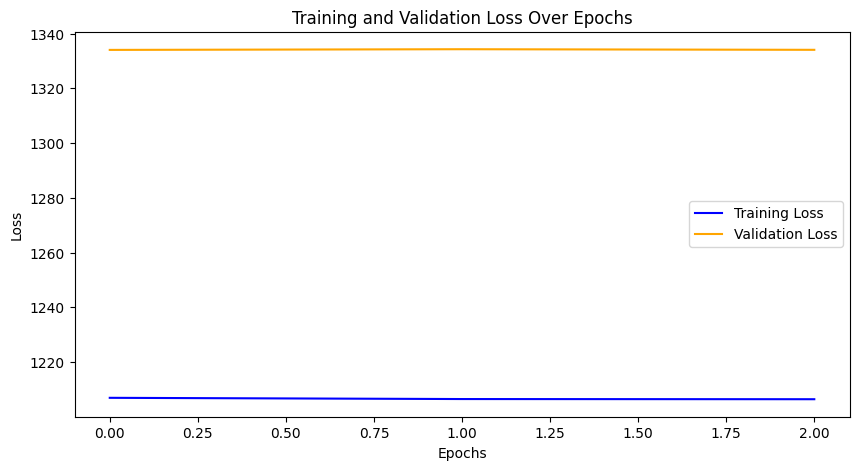

In [9]:
# Instantiate the encoder, decoder, and seq2seq model
encoder = Encoder(cnn_out_dim=32, output_dim=64).to(device)
decoder = Decoder(output_dim=3, input_dim=3, hidden_dim=64, n_layers=1).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

# Lists to track losses
train_losses = []
val_losses = []

best_val_loss = float('inf')

with open('training_losses.txt', 'w') as loss_file:
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0
        train_labels, train_predictions = [], []

        # Training loop
        for batch in train_loader:
            ref_img, half_img, strokes = batch  # Unpack your batch
            ref_img = ref_img.to(device)
            half_img = half_img.to(device)
            strokes = strokes.to(device)

            # Clear gradients
            optimizer.zero_grad()

            outputs = model(ref_img, half_img, strokes) 
            strokes = strokes.permute(1, 0, 2)

            # Calculate MSE loss for the first two channels (x and y coordinates)
            mse_loss = F.mse_loss(outputs[1:, :, :2], strokes[1:, :, :2])

            # Calculate BCE loss for the third channel (pen-up or pen-down)
            bce_loss = F.binary_cross_entropy_with_logits(outputs[1:, :, 2], strokes[1:, :, 2])

            # Total loss
            total_loss = mse_loss + bce_loss

            # Backward pass
            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Step the optimizer
            optimizer.step()

            # Accumulate training loss
            epoch_train_loss += total_loss.item()

            # Gather predictions and labels for metric calculation
            predicted = torch.sigmoid(outputs[:, :, 2])
            predicted_labels = (predicted > 0.5).float()
            train_labels.extend(strokes[:, :, 2].cpu().numpy().flatten())
            train_predictions.extend(predicted_labels.cpu().numpy().flatten())

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate additional training metrics
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0
        val_labels, val_predictions = [], []

        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                ref_img, half_img, strokes = batch  # Unpack your batch
                ref_img = ref_img.to(device)
                half_img = half_img.to(device)
                strokes = strokes.to(device)

                # Forward pass
                outputs = model(ref_img, half_img, strokes) 
                strokes = strokes.permute(1, 0, 2)

                # Calculate MSE loss for the first two channels (x and y coordinates)
                mse_loss = F.mse_loss(outputs[1:, :, :2], strokes[1:, :, :2])

                # Calculate BCE loss for the third channel (pen-up or pen-down)
                bce_loss = F.binary_cross_entropy_with_logits(outputs[1:, :, 2], strokes[1:, :, 2])

                # Total loss for validation
                total_loss = mse_loss + bce_loss
                epoch_val_loss += total_loss.item()

                # Gather predictions and labels for metric calculation
                predicted = torch.sigmoid(outputs[:, :, 2])
                predicted_labels = (predicted > 0.5).float()
                val_labels.extend(strokes[:, :, 2].cpu().numpy().flatten())
                val_predictions.extend(predicted_labels.cpu().numpy().flatten())

        # Average validation loss for the epoch
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate additional validation metrics
        val_precision = precision_score(val_labels, val_predictions)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        # Log train and validation loss along with metrics
        loss_file.write(
            f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Precision: {train_precision:.4f}, '
            f'Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, '
            f'Val Loss: {avg_val_loss:.4f}, Val Precision: {val_precision:.4f}, '
            f'Val Recall: {val_recall:.4f}, Val F1 Score: {val_f1:.4f}\n'
        )

        # Print epoch losses and metrics
        print(
            f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Precision: {train_precision:.4f}, '
            f'Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, '
            f'Val Loss: {avg_val_loss:.4f}, Val Precision: {val_precision:.4f}, '
            f'Val Recall: {val_recall:.4f}, Val F1 Score: {val_f1:.4f}'
        )

        # Save the model if the current validation loss is better than the previous best
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_save_path = '../saved_models/best_model.pth'
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with validation loss {best_val_loss:.4f}")

    # Save the last model trained after the final epoch
    last_model_save_path = '../saved_models/last_model.pth'
    torch.save(model.state_dict(), last_model_save_path)
    print(f"Last model saved as 'last_model.pth'")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Save the plot as an image file
os.makedirs('Training_Plots', exist_ok=True)
plt.savefig('../Training_Plots/training_validation_loss_plot.png')
plt.show()


In [10]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No gradients needed for validation
        for batch in test_loader:
            ref_img, half_img, strokes = batch
            ref_img = ref_img.to(device)
            half_img = half_img.to(device)
            strokes = strokes.to(device)

            outputs = model(ref_img, half_img, strokes)  # Output shape: (seq_len, batch, 3)
            strokes = strokes.permute(1, 0, 2)  # Rearranging for loss calculation

            # Calculate MSE loss for the first channel
            mse_loss = F.mse_loss(outputs[1:, :, :2], strokes[1:, :, :2])

           

            # Total loss
            total_loss += (mse_loss).item()

            # For regression (MSE metric)
            # Calculate RMSE
            rmse = torch.sqrt(mse_loss)

            # For classification
            predicted = torch.sigmoid(outputs[:, :, 2])  # Apply sigmoid to the BCE output for binary classification
            predicted_labels = (predicted > 0.5).float()  # Threshold for binary classification
            correct_predictions += (predicted_labels == strokes[:, :, 2]).sum().item()
            total_samples += strokes[:, :, 2].numel()

            # Collect all labels and predictions for metric calculation
            all_labels.extend(strokes[:, :, 2].cpu().numpy().flatten())
            all_predictions.extend(predicted_labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100  # Percentage

    # Calculate classification metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, RMSE: {rmse.item():.4f}, '
          f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Assuming you have a test DataLoader named `test_loader`
evaluate_model(model, test_loader)


/tmp/ipykernel_63581/314642015.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Test Loss: 825.6256, Accuracy: 76.00%, RMSE: 21.0099, Precision: 0.9316, Recall: 0.7391, F1 Score: 0.8242


In [30]:
# Initialize the model components
cnn_out_dim = 512  # Example CNN output dimension
output_dim = 3  # Stroke prediction output (x, y, z)
input_dim = output_dim  # Input dimension matches output_dim for LSTM
hidden_dim = 256  # Hidden dimension for LSTM
n_layers = 1  # Number of layers in LSTM
device = 'cpu'  # Using CPU for now

# Instantiate the Encoder, Decoder, and Seq2Seq models
encoder = Encoder(cnn_out_dim, output_dim)
decoder = Decoder(output_dim, input_dim, hidden_dim, n_layers)
seq2seq = Seq2Seq(encoder, decoder, device).to(device)

# Input dimensions: Assume half_img and ref_img are (batch_size, channels, height, width)
# Strokes should be (batch_size, seq_length, output_dim)
batch_size = 4
channels = 1  # Grayscale images
height = 500
width = 500
seq_length = 10  # Length of the stroke sequence

# Summary for the Encoder
summary(encoder, input_size=[(batch_size, channels, height, width),  # half_img
                             (batch_size, channels, height, width)])  # ref_img



Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [4, 3]                    --
├─Conv2dModel: 1-1                       [4, 512]                  --
│    └─Sequential: 2-1                   [4, 512]                  --
│    │    └─Conv2d: 3-1                  [4, 32, 500, 500]         320
│    │    └─ReLU: 3-2                    [4, 32, 500, 500]         --
│    │    └─MaxPool2d: 3-3               [4, 32, 250, 250]         --
│    │    └─Conv2d: 3-4                  [4, 64, 250, 250]         18,496
│    │    └─ReLU: 3-5                    [4, 64, 250, 250]         --
│    │    └─MaxPool2d: 3-6               [4, 64, 125, 125]         --
│    │    └─Conv2d: 3-7                  [4, 128, 125, 125]        73,856
│    │    └─ReLU: 3-8                    [4, 128, 125, 125]        --
│    │    └─MaxPool2d: 3-9               [4, 128, 62, 62]          --
│    │    └─Flatten: 3-10                [4, 492032]               --
│    │

In [31]:
# After the temporary adjustment to the Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input):
        # Simplified forward for the purpose of summarizing
        input = input.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        output, _ = self.rnn(input)  # Just take output, ignore hidden states for now
        prediction = self.fc_out(output)
        return prediction
    
decoder = Decoder(output_dim, input_dim, hidden_dim, n_layers)

summary(decoder, input_size=(batch_size, input_dim))


Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [4, 1, 3]                 --
├─LSTM: 1-1                              [4, 1, 256]               267,264
├─Linear: 1-2                            [4, 1, 3]                 771
Total params: 268,035
Trainable params: 268,035
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.07
Estimated Total Size (MB): 1.08